# Apartment Hunting

How might you approach the problem of recognizing a good deal from a bad deal?

Housing Markets are difficult to predict:
- Continually changing marketplace
- Many factors that play into one decision
- Different features have different values to renters/rentees

### 1. Formalize a Question 

What is the predicted housing price, and is the listing I'm looking at above or below what my model predicts?

### 2. What information do we need/would be helpful to answer this question? Where do we find it?

https://portland.craigslist.org/d/apts-housing-for-rent/search/mlt/apa
Dependent Variable:
* price

Potential Independent variables:
* availability dates
* bed/bathrooms
* square footage
* cats/dogs
* listing content (length, text)
* photos (number posted, color analysis?)
* has map? 
* latitude/longitude
* parking, smoking, laundry, furnished, wheelchair

External Data?
* neighborhood boundries/shape files?
* census data?
* walkscore api? proximity?
* 




### 3. What patterns do we see in the data? EDA

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
df = pd.read_csv('../shared-resources/AptData.csv')
df.describe(include='all')

,Unnamed: 0,available,bath,bed,cat,content,content_length,date,dog,feet,...,lastseen,lat,laundry,long,parking,price,smoking,time,title,wheelchair
count,5.966800e+04,59662,57955.000000,57955.000000,59668.000000,59668,59668.000000,59668,59668.000000,52002.000000,...,35194,56280.000000,54706,56280.000000,45358,5.960300e+04,59662.0,59668,59668,59662.0
unique,NaN,418,NaN,NaN,NaN,42098,NaN,172,NaN,NaN,...,57,NaN,5,NaN,7,NaN,NaN,32748,37617,NaN
top,NaN,2017-03-01,NaN,NaN,NaN,Manger Special: $100 off rent for the first 6...,NaN,2017-05-30,NaN,NaN,...,2017-05-31,NaN,w/d in unit,NaN,off-street parking,NaN,NaN,10:21:45,1 AND 2 BED AVAILABLE,NaN
freq,NaN,1714,NaN,NaN,NaN,326,NaN,763,NaN,NaN,...,1748,NaN,34855,NaN,14897,NaN,NaN,8,132,NaN
mean,6.049989e+09,NaN,1.283944,1.436287,0.715258,NaN,222.731632,NaN,0.667510,888.145417,...,NaN,45.518263,NaN,-122.628349,NaN,2.802600e+03,0.0,NaN,NaN,0.0
std,6.018319e+07,NaN,0.513810,0.934212,0.451295,NaN,119.112952,NaN,0.471109,2384.246357,...,NaN,0.134953,NaN,0.507698,NaN,1.253909e+05,0.0,NaN,NaN,0.0
min,5.920380e+09,NaN,0.000000,0.000000,0.000000,NaN,3.000000,NaN,0.000000,1.000000,...,NaN,27.939305,NaN,-124.018466,NaN,1.000000e+00,0.0,NaN,NaN,0.0
25%,6.001450e+09,NaN,1.000000,1.000000,0.000000,NaN,143.000000,NaN,0.000000,604.000000,...,NaN,45.504798,NaN,-122.687025,NaN,1.190000e+03,0.0,NaN,NaN,0.0
50%,6.042061e+09,NaN,1.000000,1.000000,1.000000,NaN,212.000000,NaN,1.000000,789.000000,...,NaN,45.519138,NaN,-122.668855,NaN,1.399000e+03,0.0,NaN,NaN,0.0
75%,6.096789e+09,NaN,1.500000,2.000000,1.000000,NaN,287.000000,NaN,1.000000,1000.000000,...,NaN,45.532877,NaN,-122.612359,NaN,1.795000e+03,0.0,NaN,NaN,0.0


**Notable Highlights**
- Why are there 418 available dates?
- Majority of apartments allow dogs and cats
- WHOA!!! only 42000 unique contents? There's like 20000 repetitions. 326 repetitions at the most.
    - Do analysis on biggest spammer
    - Same for titles, only 37000 unique titles, perhaps some overlap for unoriginal titles
- Doesn't look like the furnished/smoking/wheelchair variables worked - there were no listing with furnished.
- 1250 is the most common price

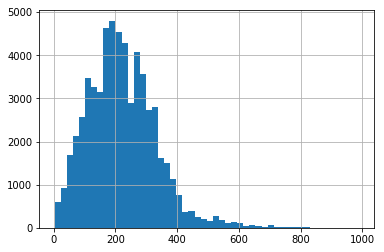

In [22]:
pd.to_numeric(df[df['content_length']<1000]['content_length']).hist(bins=50)

Right skewed distribution. Why is there a gap at around 240-260? My guess is that there are tons of duplicate postings that are just above 260. I'd be interested to see what they look like without the duplicate entries.

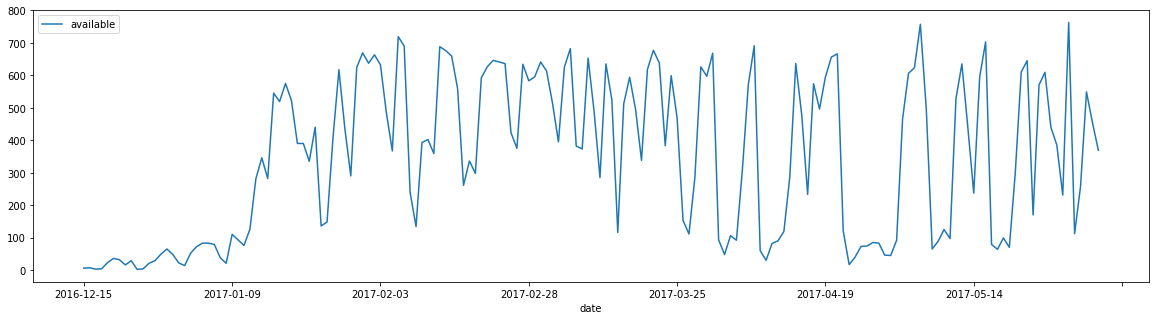

In [23]:
df[['date','available']].groupby('date').count().plot(figsize=(20,5))

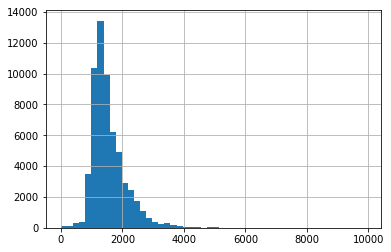

In [24]:
pd.to_numeric(df[df['price']<10000]['price']).hist(bins=50)

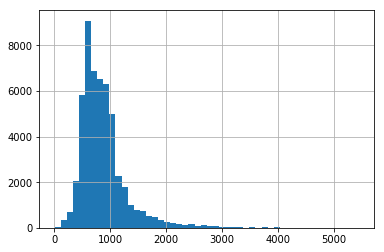

In [25]:
pd.to_numeric(df[df['feet']<6000]['feet']).hist(bins=50)

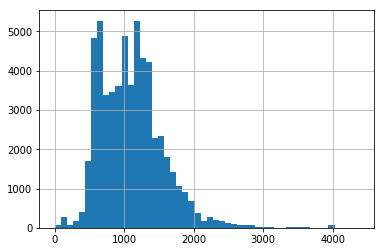

In [26]:
studiodf = df.copy()
studiodf['bed'] = studiodf['bed'].replace(0,1)

studiodf = studiodf[studiodf['price']<10000]
(studiodf.price / studiodf.bed).hist(bins=50)

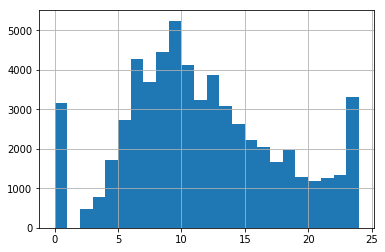

In [27]:
df['getphotos'].hist(bins=24)

Looks like it's just as popular to post 0 photos as it is to max out the number of photos

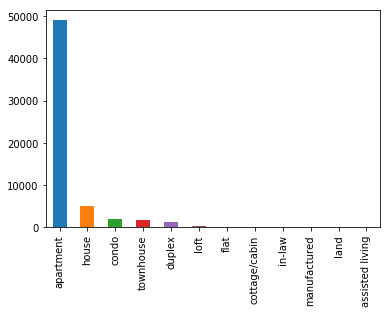

In [28]:
df['housingtype'].value_counts().plot(kind='bar')

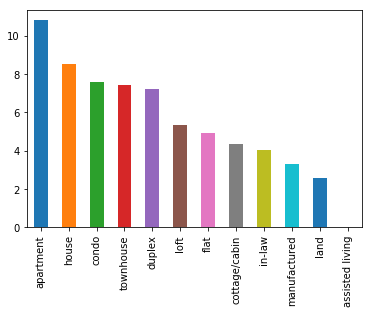

In [31]:
# For perspective, take the log transform
np.log(df['housingtype'].value_counts()).plot(kind='bar')

In [32]:
df['housingtype'].value_counts()

apartment          49047
house               5110
condo               1977
townhouse           1648
duplex              1350
loft                 204
flat                 136
cottage/cabin         76
in-law                55
manufactured          27
land                  13
assisted living        1
Name: housingtype, dtype: int64

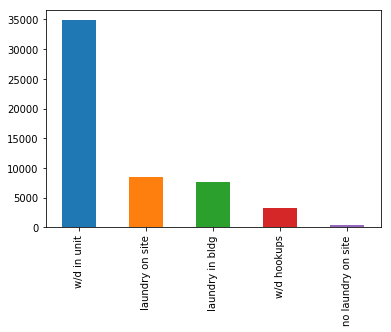

In [33]:
df['laundry'].value_counts().plot(kind='bar')

In [38]:
continuousdf = df[(df['price']<10000) & (df['content_length']<1000) & (df['feet']<6000)][['bath','bed','content_length','feet','getphotos','price']]

In [44]:
continuousdf = continuousdf.dropna()

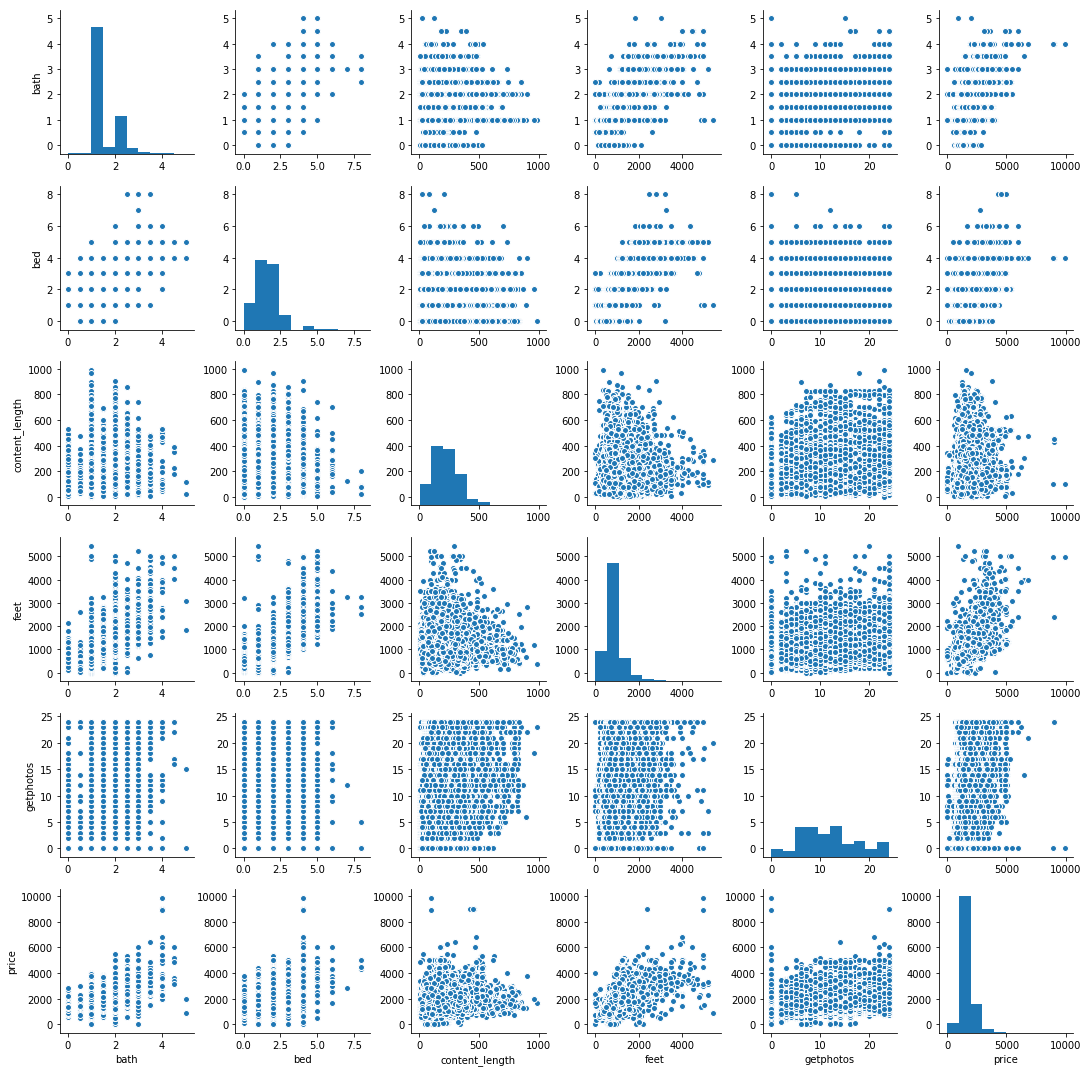

In [45]:
sns.pairplot(continuousdf[['bath','bed','content_length','feet','getphotos','price']])

In [46]:
geo = df[['lat','long']].dropna()

In [47]:
geo['lat'] = pd.to_numeric(geo['lat'])
geo['long'] = pd.to_numeric(geo['long'])

In [48]:
# Filter values so that they fit in the viz
geo = geo[(geo['lat']>45.4) & (geo['lat']<45.6)]
geo = geo[(geo['long']<-122.3)& (geo['long']>-123)]

In [52]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [53]:
cl = KMeans(n_clusters=34)
cl.fit(geo)
centers = cl.cluster_centers_

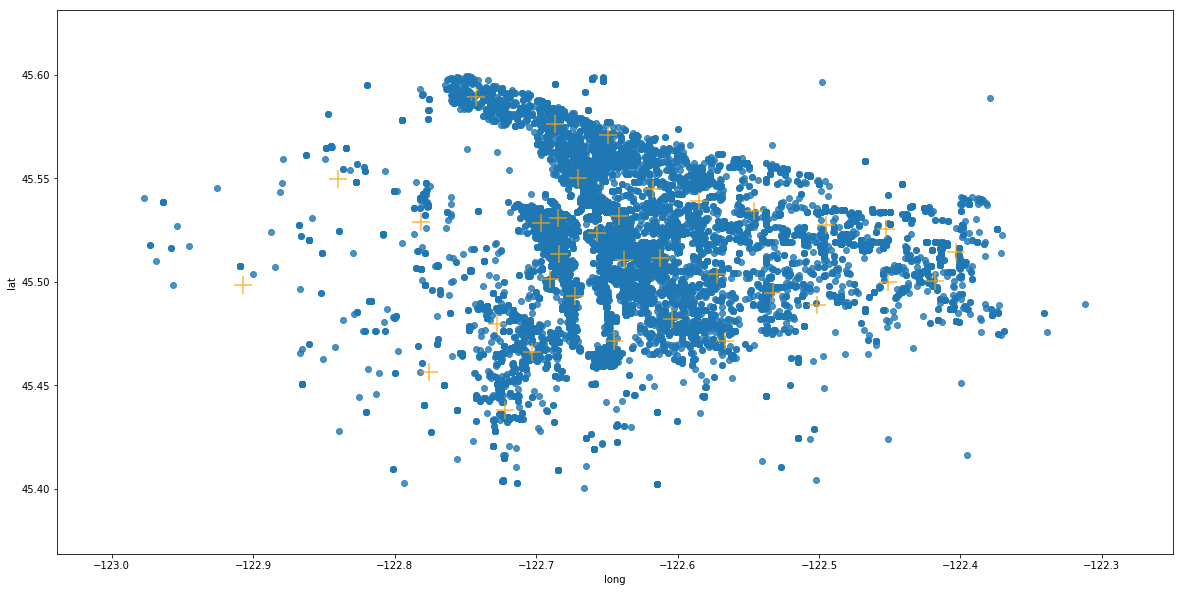

In [54]:
dims = (20, 10)
fig, ax = plt.subplots(figsize=dims)
sns.regplot(geo.long,geo.lat, fit_reg=False,ax=ax)
sns.regplot(centers[:,1],centers[:,0],fit_reg=False, color='orange',marker="+",scatter_kws={"s": 300})

### 4. What methods might we use to answer our question?

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(
    continuousdf.drop(['price'],axis=1), 
    continuousdf['price'],
    test_size=0.33, 
    random_state=42)




In [70]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [73]:
pred = rf.predict(X_test)

In [81]:
r2_score(pred, y_test)

0.77072019381388912

### 5. How do we explain our results?